In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df.iloc[:, 12:17].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [3]:
dataset = CustomDataset("180801_RFB_510cy_006_DC.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(262407, 5)
float64
(262407, 1)
float64


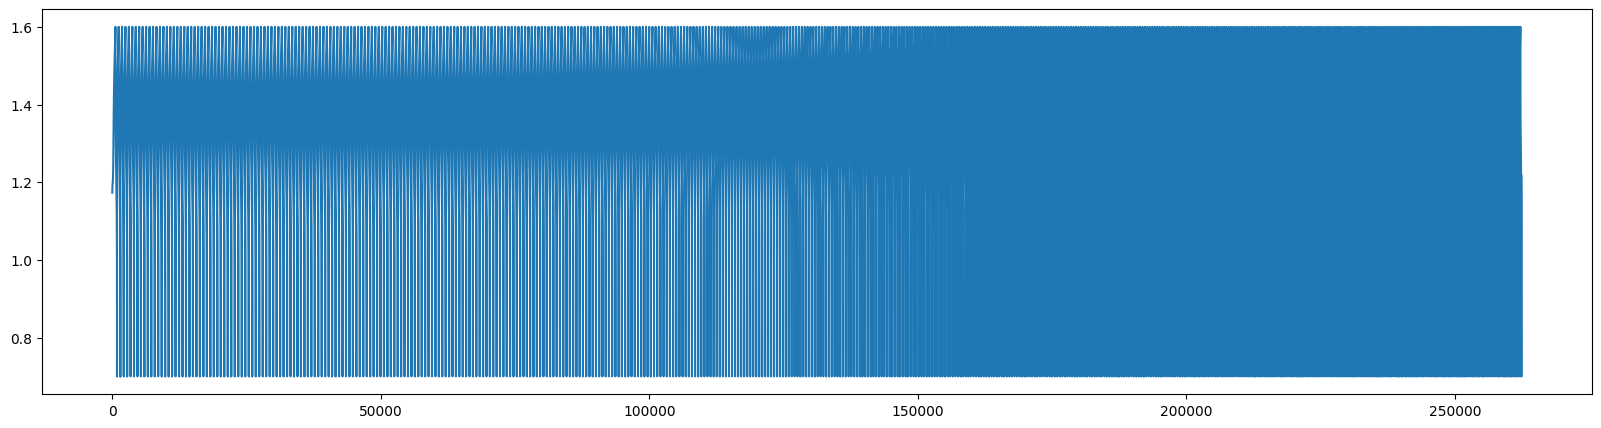

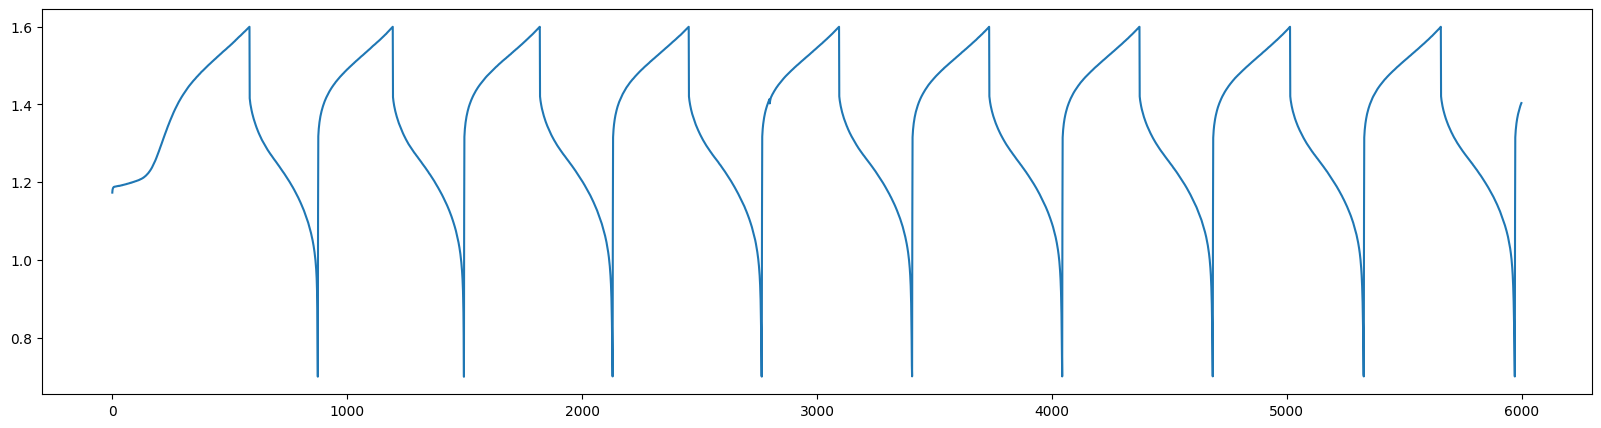

In [4]:
plt.figure(figsize=(20,5))
plt.plot(dataset.y)

plt.figure(figsize=(20,5))
plt.plot(dataset.y[:6000])
plt.show()

In [5]:
# X_train = X[:200000]
# X_test = X[200000:]

# y_train = y[:200000]
# y_test = y[200000:] 

# print(X_train.dtypes)
# print("Training Shape", X_train.shape, y_train.shape)
# print("Testing Shape", X_test.shape, y_test.shape) 

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# X_train = X[:train_size]
# X_val = X[train_size:(train_size + validation_size)]
# X_test = X[(train_size + validation_size):(train_size + validation_size +test_size)]



print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 209925
Validation Data Size : 26240
Testing Data Size : 26242


In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [7]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers 
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.seq_length = seq_length 

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.batchnormal = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes) 

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) 
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
        hn = hn.view(-1, self.hidden_size) 
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [8]:
num_epochs = 1000 
learning_rate = 0.01

input_size = 5 
hidden_size = 32
num_layers = 1 

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, dataset.x.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
writer = SummaryWriter()

def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [10]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [11]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(num_epochs):
    #print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    writer.add_scalar("Loss/train", train_epoch_loss, epoch)
    val_epoch_loss, val_epoch_accuracy = validate(
        model, validation_dataloader, validation_dataset, criterion
    )
    writer.add_scalar("Loss/val", val_epoch_loss, epoch)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if epoch % 100 == 0:
        print("Train Loss: %e, Train Acc: %.2f" %(train_epoch_loss, train_epoch_accuracy))
        print('Val Loss: %e, Val Acc: %.2f' %(val_epoch_loss, val_epoch_accuracy))
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

writer.flush()
writer.close()

Training


  0%|          | 0/820 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_25300\3594872476.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  feature = torch.FloatTensor([self.x[index]])
100%|██████████| 820/820 [00:05<00:00, 157.66it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 1581.11it/s]


Train Loss: 1.474333e-02, Train Acc: 0.00
Val Loss: 1.607336e-04, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:04<00:00, 168.59it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 1532.31it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 164.76it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1716.25it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1753.34it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1664.73it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 165.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1654.81it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 175.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1746.54it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1808.16it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1796.28it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 165.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1744.68it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1755.89it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1739.13it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1796.28it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1728.14it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1771.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.75it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1771.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1826.28it/s]


Training


100%|██████████| 820/820 [00:05<00:00, 162.62it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1765.34it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1838.57it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.03it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1726.32it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1764.16it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 165.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1708.63it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1710.12it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1761.55it/s]


Training


100%|██████████| 820/820 [00:05<00:00, 160.45it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 1590.73it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 167.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1779.90it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1756.33it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1798.95it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1807.15it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1893.03it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1911.71it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1910.58it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 191.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1822.59it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1913.75it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 189.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1880.74it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 188.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1887.76it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1944.76it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1775.68it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1733.20it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1755.01it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1753.32it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1782.51it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1767.46it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 173.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1820.07it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1768.35it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1732.76it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1760.68it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1763.51it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1692.22it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1730.62it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1784.11it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1833.49it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1799.38it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1699.77it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1749.22it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1777.55it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1742.41it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1743.67it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 175.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1739.68it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.36it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1761.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1769.42it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1765.43it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1756.01it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1752.81it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.50it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1760.52it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.00it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1738.74it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1794.24it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1907.32it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 191.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1912.48it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1882.58it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 188.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1883.73it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1889.40it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 189.97it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1911.79it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1900.85it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1775.05it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1871.72it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1875.81it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1784.10it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1798.15it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1811.23it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1747.96it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.55it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1763.23it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1755.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1802.54it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 173.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1648.92it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1761.97it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 169.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1776.31it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 175.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1698.11it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 167.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1775.51it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1811.61it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1739.75it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1669.41it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1773.20it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1771.05it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1767.55it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 165.33it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1761.54it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1771.01it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.17it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1773.23it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1782.82it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 166.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1738.37it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 167.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1744.82it/s]


Train Loss: 7.786727e-06, Train Acc: 0.00
Val Loss: 6.631273e-07, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:04<00:00, 171.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1732.90it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 165.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1760.50it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 173.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1783.25it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 169.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1747.94it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 166.00it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1670.16it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1715.36it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 164.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1722.24it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1842.48it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.76it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1867.49it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.54it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1883.38it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1914.98it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1834.34it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1894.32it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1900.40it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 188.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1915.95it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.75it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1836.33it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 189.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1945.83it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1906.07it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.30it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1761.39it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1812.22it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1778.43it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1713.70it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 165.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1763.31it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 166.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1776.09it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1747.65it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1756.00it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1764.23it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1769.13it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 173.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1783.49it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 169.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1746.62it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 167.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1741.07it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1786.84it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 166.54it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1763.19it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1762.03it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1790.17it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 173.39it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1793.91it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1744.72it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 165.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1767.46it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 171.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1770.28it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 167.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1749.78it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1772.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 166.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1769.42it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 168.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1793.96it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 173.36it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1770.65it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 167.24it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1775.51it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.30it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1670.16it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 167.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1743.66it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 170.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1756.14it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 169.45it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1759.77it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 172.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1888.33it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1890.09it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.89it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1843.40it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1866.97it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1861.29it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1824.68it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1866.36it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1769.08it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1868.04it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1857.30it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1889.32it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1873.40it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1879.49it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.81it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1913.23it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1876.38it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1887.97it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1897.15it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1899.13it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1857.48it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1900.76it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1868.76it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1891.24it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1885.60it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1868.70it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1914.26it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1917.54it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1869.88it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1928.47it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.55it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1904.87it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1883.69it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1928.70it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1796.81it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.32it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1891.14it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1891.34it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1859.59it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1860.10it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.73it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 1555.06it/s]


Training


100%|██████████| 820/820 [00:05<00:00, 151.12it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 1513.64it/s]


Training


100%|██████████| 820/820 [00:05<00:00, 156.24it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1773.35it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 169.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1788.42it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 166.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1864.81it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1871.68it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1874.49it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1904.31it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1873.17it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1868.51it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1895.36it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1885.55it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1904.26it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1900.46it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1877.96it/s]


Train Loss: 4.631885e-06, Train Acc: 0.00
Val Loss: 1.480633e-05, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:04<00:00, 183.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1889.74it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1879.19it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1904.72it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1876.07it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1882.51it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.22it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1864.85it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1792.72it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 188.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1870.14it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1902.21it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1910.17it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1876.29it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1911.43it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.49it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1871.69it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1881.26it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.32it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1899.93it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1882.90it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1886.40it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1894.82it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.24it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1913.46it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1904.52it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1854.30it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1759.07it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1902.86it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1893.81it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1897.59it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.89it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1850.14it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1901.70it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1893.20it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1874.86it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.50it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1918.28it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1836.55it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1842.74it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.24it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1790.37it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1861.76it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1906.56it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1873.66it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1887.84it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1883.46it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1896.26it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.62it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1877.93it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1903.96it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.30it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1874.42it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1898.76it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1811.80it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1854.71it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1916.74it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1909.92it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1846.03it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1858.84it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.63it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1892.36it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1848.65it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1900.36it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1872.80it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1856.17it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1871.37it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1846.18it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1830.93it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1888.91it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.50it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1799.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1825.87it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1835.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1851.88it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1936.17it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.93it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1936.54it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1847.10it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.97it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1882.55it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1875.92it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1865.75it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1908.49it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1914.29it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1852.59it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1855.09it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1859.38it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1668.27it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.03it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1861.61it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1868.87it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1850.71it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1904.85it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 186.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1890.78it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1882.17it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1874.59it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1913.00it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1873.44it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.81it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1889.16it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1895.34it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1915.24it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1865.21it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1868.71it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 175.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1846.95it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1898.94it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1921.58it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1901.67it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1852.04it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1929.65it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 188.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1928.36it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.55it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1842.89it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1867.77it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.03it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1799.57it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 177.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1903.79it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1849.42it/s]


Train Loss: 3.641384e-06, Train Acc: 0.00
Val Loss: 3.946411e-07, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:04<00:00, 178.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1870.66it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1912.89it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1908.99it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1668.46it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1895.84it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1867.67it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 175.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1847.27it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 174.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1848.94it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1911.53it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.62it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1898.11it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.00it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1879.36it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1898.01it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.76it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1923.34it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 186.36it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1871.61it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.54it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1810.86it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1867.56it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1908.35it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 175.49it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1827.11it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.22it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1847.19it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1842.79it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.17it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1856.84it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1869.22it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1884.70it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 186.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1857.55it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1896.25it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1850.22it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1883.78it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 175.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1883.14it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 185.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1884.49it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1782.73it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1841.63it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1896.23it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1874.30it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1899.50it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1922.96it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 188.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1914.13it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1838.64it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.00it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1814.62it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1794.02it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 189.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1895.32it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1896.84it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 181.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1885.54it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 190.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1851.35it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 184.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1853.92it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 187.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1805.58it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1877.20it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1886.38it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 179.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1839.81it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 176.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1903.06it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1870.02it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 183.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1934.75it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 193.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1932.82it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 188.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1934.68it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 178.81it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2075.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 215.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2058.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 209.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2141.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2104.85it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 204.81it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1888.22it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 201.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2123.56it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 206.81it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1797.93it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 182.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1970.34it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 201.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1928.93it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 203.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2064.92it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 212.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2035.45it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 202.55it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2050.14it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 196.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1898.40it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 201.75it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2067.70it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 198.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2030.25it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 213.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2122.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 207.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2089.38it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 207.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1961.79it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 180.49it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1658.97it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 169.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1841.37it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 206.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2072.18it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 212.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2018.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 205.24it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2017.73it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 201.45it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1967.44it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 205.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2072.38it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 203.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2063.73it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 207.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2040.42it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 207.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2065.35it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 193.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2099.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 213.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2113.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 205.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1955.03it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 199.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2062.77it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 207.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2117.24it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 203.30it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2073.78it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2099.93it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 214.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2142.86it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2132.18it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 206.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2105.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 210.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2054.93it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 208.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2004.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 212.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2084.13it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2065.32it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2157.10it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.97it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2215.90it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2217.88it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2194.57it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.55it/s]


Train Loss: 2.437818e-06, Train Acc: 0.00
Val Loss: 4.131523e-07, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:03<00:00, 219.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2169.42it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2140.01it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 208.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2170.99it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2155.56it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2214.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2229.89it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2020.82it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 202.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.72it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2188.29it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.42it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2196.73it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2103.14it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.70it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2191.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.62it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2181.18it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 212.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2248.99it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.25it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2102.57it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.89it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2274.64it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.29it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2274.62it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.50it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2237.38it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2326.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2157.90it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2290.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.30it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2129.87it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2271.47it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.51it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.89it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2160.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2258.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.35it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.40it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2121.61it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2262.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2258.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2240.44it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2097.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2249.65it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.35it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2265.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2105.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.97it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.76it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2169.32it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2246.58it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.76it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2086.51it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2237.38it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.89it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.76it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2110.68it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.24it/s]


Train Loss: 2.016470e-06, Train Acc: 0.00
Val Loss: 5.052776e-06, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:03<00:00, 229.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2252.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 200.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2121.61it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 211.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2216.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 206.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2110.76it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 210.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2209.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.30it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2197.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.04it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 208.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2097.09it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 202.45it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2028.60it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 202.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2031.37it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2188.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.06it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.03it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2202.05it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2224.20it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2098.04it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2135.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 214.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2115.95it/s]


Training


100%|██████████| 820/820 [00:04<00:00, 203.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2048.20it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 214.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2084.97it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 213.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.05it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 209.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2151.05it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 208.76it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2172.83it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2208.49it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.33it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.51it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.93it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2156.76it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2059.89it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2124.83it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1966.04it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 205.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1934.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 209.45it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1941.05it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 210.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2124.08it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2220.29it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2236.88it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2148.10it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2154.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.63it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2271.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2235.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.62it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2246.18it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2085.84it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.39it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2208.92it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2130.47it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.00it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.24it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2216.55it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2214.70it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2257.99it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2269.43it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2218.53it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.91it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2221.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.88it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2094.36it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2217.97it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.10it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2252.35it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2241.72it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2107.56it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2185.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2174.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2157.94it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2211.37it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2227.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2244.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.80it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2218.87it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2215.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2104.98it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2194.54it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.88it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 232.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.30it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2230.53it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2184.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.05it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2260.78it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2104.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2237.37it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2245.37it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2153.70it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.16it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2162.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2194.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2206.99it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2163.80it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.22it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2244.65it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.04it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2094.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2247.98it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2151.12it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2244.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2238.90it/s]


Train Loss: 1.996897e-06, Train Acc: 0.00
Val Loss: 5.120038e-07, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:03<00:00, 216.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2150.78it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2150.49it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 215.17it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2108.16it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2200.63it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2253.46it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.84it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2249.13it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2202.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2170.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2167.00it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2159.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.98it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2226.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.54it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2205.37it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2240.65it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.08it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2068.01it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2190.14it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2206.60it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2158.54it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2220.36it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.03it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2165.57it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.00it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2200.15it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2122.35it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.37it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2193.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2170.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2051.13it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2163.28it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2224.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2187.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2223.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.05it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.24it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2159.43it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.83it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.75it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2214.17it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2220.05it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.93it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2178.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.17it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2203.11it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2178.91it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2155.14it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.88it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2155.32it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.67it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2194.81it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2166.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2075.56it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2110.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2202.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.76it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2256.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 216.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.76it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2239.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.55it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2131.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2269.10it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.86it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2137.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2238.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2217.36it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2205.13it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2209.09it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.92it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2230.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.45it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2281.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2272.51it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.32it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.09it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2232.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.32it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2174.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.63it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2188.12it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.48it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.50it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2172.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2148.98it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2229.58it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2173.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.57it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2135.44it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2149.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.89it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2252.08it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2154.91it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.38it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2227.98it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2182.01it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 231.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2153.01it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2152.03it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2028.42it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.55it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.32it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2218.12it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.16it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2200.56it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.47it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2226.99it/s]


Train Loss: 1.697277e-06, Train Acc: 0.00
Val Loss: 8.160016e-06, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:03<00:00, 222.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2212.92it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 231.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2220.62it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2165.83it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2203.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2249.01it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.72it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2224.11it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2238.06it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2196.56it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2163.98it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2193.35it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.33it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2173.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.63it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2167.78it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.12it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2144.72it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2148.48it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.88it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2148.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2199.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2118.28it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2152.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.33it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2171.65it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2196.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2220.89it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2188.57it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2220.09it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2238.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2191.54it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2223.12it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2141.71it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2127.99it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2227.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2185.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2215.10it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2080.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2184.86it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.00it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2178.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.36it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2203.02it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.94it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2164.64it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2184.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2082.15it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2224.81it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2230.78it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.03it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2209.63it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2165.92it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.23it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2174.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.54it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2173.70it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.32it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2194.47it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2250.44it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2182.71it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2209.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2224.09it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2091.70it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2049.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.11it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2214.46it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2169.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2150.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.00it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2212.53it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2205.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2119.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2158.82it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.18it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2155.81it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2224.20it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2206.68it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2259.51it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2097.65it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2179.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2178.29it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2288.13it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.51it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2144.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.89it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2178.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2023.83it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.03it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2205.54it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2162.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.87it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2226.56it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.33it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2223.64it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2179.00it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2247.48it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.22it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2224.92it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.07it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.70it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.61it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2230.70it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.62it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2121.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2218.83it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.54it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2211.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.97it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2132.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.06it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2193.43it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.75it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2172.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2182.32it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.12it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 1943.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2262.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2163.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2237.38it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.91it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2265.20it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2089.17it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.34it/s]


Train Loss: 1.745275e-06, Train Acc: 0.00
Val Loss: 5.423183e-07, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:03<00:00, 227.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2118.86it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2262.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.22it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.22it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2146.60it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2068.10it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2110.68it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2155.06it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.32it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2157.90it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2252.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2249.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2143.79it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2246.58it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2216.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.29it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2160.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.10it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2169.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.25it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.49it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2268.20it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2240.44it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.69it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2169.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2157.90it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2097.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.09it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2075.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2240.44it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2290.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.05it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.50it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2135.42it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2249.66it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2099.88it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.76it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2140.99it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.14it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.99it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2246.57it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2252.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.66it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2240.44it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2246.58it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2155.06it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2166.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2237.25it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.76it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.51it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.34it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.29it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2216.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.41it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2160.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2262.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.47it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.25it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2240.43it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2113.40it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.60it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.95it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.35it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2265.20it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2280.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Train Loss: 1.894324e-06, Train Acc: 0.00
Val Loss: 9.079196e-08, Val Acc: 0.00
Training


100%|██████████| 820/820 [00:03<00:00, 223.49it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.25it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.20it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2129.87it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.11it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.82it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.68it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.35it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2149.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2249.68it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.49it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2172.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2160.73it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.39it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.54it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2086.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2222.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.64it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.39it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2216.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.96it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.80it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2265.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2086.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2152.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2157.89it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2152.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2252.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2246.57it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.48it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2258.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.52it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.01it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.27it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2081.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.29it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2243.50it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.33it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 218.73it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.63it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2160.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.40it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2198.40it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2152.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2152.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.26it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2237.38it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.62it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2160.74it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.08it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2166.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 228.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.49it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2228.26it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.28it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2097.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.38it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2252.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2149.41it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.97it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.50it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2207.27it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.77it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.29it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 217.45it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.98it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2121.61it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.22it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2268.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.19it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.95it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 215.85it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.43it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2189.59it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2195.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.37it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.65it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2118.87it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.16it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2124.35it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.15it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2166.45it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.04it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2201.34it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.74it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.56it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.55it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.13it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2183.75it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 225.90it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2231.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.84it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2157.90it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.63it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2255.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.71it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2219.21it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.31it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2225.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.59it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.52it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 220.61it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2210.24it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 224.53it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2234.33it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 219.78it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2177.96it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.46it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2186.67it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.21it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2097.19it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 222.58it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2192.51it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 226.83it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2204.30it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2169.31it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 230.79it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2081.22it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.92it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2180.85it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 227.02it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.23it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 223.86it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2175.07it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 221.44it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2121.61it/s]


Training


100%|██████████| 820/820 [00:03<00:00, 229.76it/s]


Validating


100%|██████████| 1640/1640 [00:00<00:00, 2213.22it/s]

Training time: 80.380 minutes


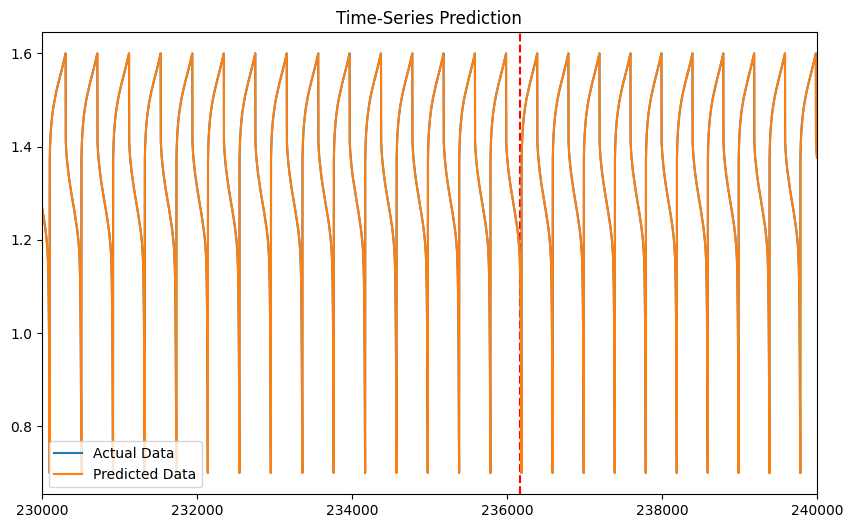

In [12]:
df_x_ss = dataset.x
df_y_ms = dataset.y

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()


plt.figure(figsize=(10,6)) 
plt.axvline(x=dataset_size-test_size, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.xlim([230000, 240000])
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

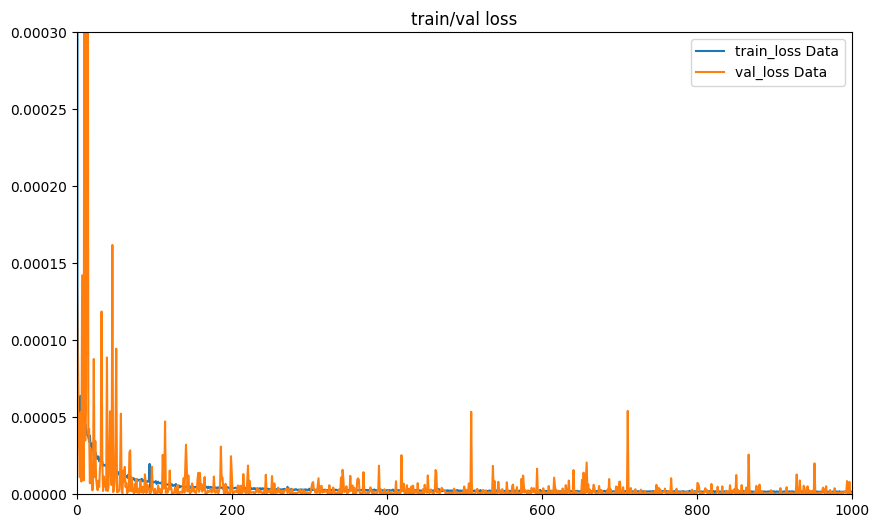

In [13]:
plt.figure(figsize=(10,6))

plt.plot(train_loss, label='train_loss Data') 
plt.plot(val_loss, label='val_loss Data') 
plt.title('train/val loss')
plt.xlim([0, 1000])
plt.ylim([0, 0.0003])
plt.legend()
plt.show()


In [14]:
print("train_loss(990~1000) : ",np.mean(train_loss[990:1000]))
#print(np.mean(val_loss[990:1000]))

train_loss(990~1000) :  1.6513112166467283e-06
